In [128]:
#6.1

import pandas as pd
from sklearn.decomposition import PCA

df = pd.read_csv('./nyt-frame.csv', header = 0)
data = df.iloc[:,9:]
array = data.values

pca = PCA(n_components=10)
nyt_pca = pca.fit_transform(array)

nyt_target = df.iloc[:,1].values

In [129]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
bc_data = bc.data
bc_target = bc.target

pca = PCA(n_components=10)
bc_pca = pca.fit_transform(bc_data)

Powyżej wczytaliśmy dane ze zbiorów "NYT" i "Breast Cancer", oraz zredukowaliśmy ich wymiarowość do dziesięciu wymiarów używając PCA.

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_values = [1, 3, 5, 7]

search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': k_values,
    },
    cv=10,
    scoring='accuracy'
)

search.fit(nyt_pca, nyt_target)
for k, accuracy in zip(k_values, search.cv_results_['mean_test_score']):
    print(f'k={k}, accuracy={accuracy}')

k=1, accuracy=0.8809090909090911
k=3, accuracy=0.8800000000000001
k=5, accuracy=0.890909090909091
k=7, accuracy=0.8527272727272728


Dla danych ze zbioru *NYT* najlepszą dokładność uzyskujemy dla pięciu najbliższych sąsiadów, ale skorzystanie z trzech lub jednego sąsiada da również bardzo zbliżony wynik. Zwiększenie liczby najbliższych śąsiadów do siedmiu zmniejszy dokładność klasyfikacji o 3-4%.

In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

search.fit(bc_pca, bc_target)
for k, accuracy in zip(k_values, search.cv_results_['mean_test_score']):
    print(f'k={k}, accuracy={accuracy}')

k=1, accuracy=0.9156954887218045
k=3, accuracy=0.9261904761904761
k=5, accuracy=0.9297619047619046
k=7, accuracy=0.9279761904761905


W przypadku zbioru *Breast Cancer*, najlepsza dokładność wyszła dla pięciu najbliższych sąsiadów, ale użycie siedmiu, trzech lub nawet tylko jednego nie powinna znacznie obniżyć jakości.  

Należy dodać, iż dla klasyfikatora z obu powyższych punktów użyta zostana domyślna metryka Minkowskiego a wagi nie zależą od dystansu punktów od siebie.

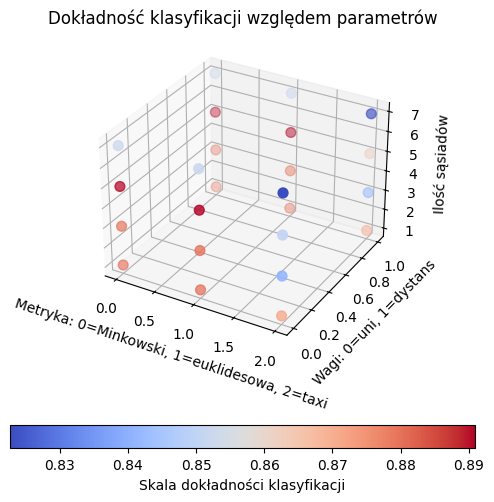

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(data, target):
    accuracies = []
    params = []

    k_values = [1, 3, 5, 7]

    comparison = GridSearchCV(
        KNeighborsClassifier(),
        {
            'n_neighbors': k_values,
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'cityblock']
        },
        cv=10,
        scoring='accuracy'
    )

    comparison.fit(data, target)
    accuracies = np.array(comparison.cv_results_['mean_test_score'])
    params = np.array(list(map(lambda t: [0 if t['metric'] == 'minkowski' else 1 if t['metric'] == 'euclidean' else 2,\
                                0 if t['weights'] == 'uniform' else 1,\
                                t['n_neighbors']], comparison.cv_results_['params'])))

    fig = plt.figure(figsize=(6, 6))
    points = fig.add_subplot(111, projection='3d')

    points.scatter(params[:, 0], params[:, 1], params[:, 2], c=accuracies, cmap='coolwarm', s=50)
    points.set_xlabel('Metryka: 0=Minkowski, 1=euklidesowa, 2=taxi'),
    points.set_ylabel('Wagi: 0=uni, 1=dystans')
    points.set_zlabel('Ilość sąsiadów')
    points.set_title('Dokładność klasyfikacji względem parametrów')

    cbar = plt.colorbar(points.collections[0], ax=points, orientation='horizontal')
    cbar.set_label('Skala dokładności klasyfikacji')

    plt.show()

plot_comparison(nyt_pca, nyt_target)

Porównując zestawienie kilku parametrów klasyfikatora k-NN dla zbioru *NYT* można zaobserować następujące zależności:
- Metryka Minkowskiego i euklidesowa dają lepsze rezultaty klasyfikacji od metryki taxi
- Nie używania wag dystansu i traktowanie wszystkich punktów w sąsiedztwie jednakowo da minimalnie lepszą dokładność klasyfikacji
- Optymalną ilością sąsiadów, dla niemalże każdej kombinacji pozostałych parametrów, jest 5. 

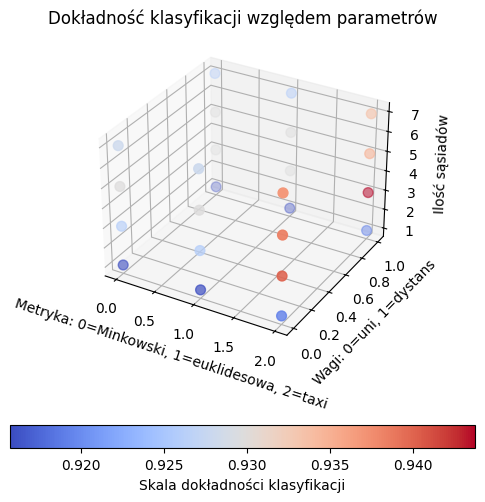

In [133]:
plot_comparison(bc_pca, bc_target)

Porównajmy zestawienie takich samych parametrów dla zbioru *Breast Cancer*:
- Metryka taxi da wyraźnie lepsze rezultaty od pozostałych dwóch testowanych metryk
- Użycie dystansu pomiędzy sąsiadami polepszy jakość klasyfikacji
- Optymalną liczbą najbliższych sąsiadów jest 3.


Generalnie zauważamy, że parametryzacja klasyfikatora k-NN powinna mocno zależeć od użytego zbioru danych i zdecydowanie warto użyć walidacji krzyżowej, aby wybrać odpowiednie wartości parametrów dla każdego z modeli.

In [134]:
import sys
!{sys.executable} -m pip install binarytree

47896.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [135]:
from binarytree import Node
import numpy as np

sample_3d = np.array([[1, 9, 4], [2, 3, 2], [4, 1, 7], [3, 7, 4], [5, 4, 9], [6, 8, 2], [7, 2, 1], [8, 8, 7], [7, 9, 6], [9, 6, 8]])



def create_kd_tree(listOfPoints, depth):
    node = None
    if len(listOfPoints) > 0:
        axis = depth % listOfPoints.shape[1]
        median = np.median(listOfPoints, axis=0)[axis]
        
        left = []
        right = []
        for point in listOfPoints:
            if point[axis] < median:
                left.append(point)
            elif point[axis] > median:
                right.append(point)

        node = Node(f'ax:{axis},m:{median}')

        node.left = create_kd_tree(np.array(left), depth+1)
        node.right = create_kd_tree(np.array(right), depth+1)

    return node

root = create_kd_tree(sample_3d, 0)

print(root)


                                       ________________ax:0,m:5.5_____________________________________
                                      /                                                               \
                 ________________ax:1,m:4.0____                                    ________________ax:1,m:8.0____
                /                              \                                  /                              \
      _____ax:2,m:4.5____                   ax:2,m:4.0                  _____ax:2,m:4.5____                   ax:2,m:6.0
     /                   \                                             /                   \
ax:0,m:2.0            ax:0,m:4.0                                  ax:0,m:7.0            ax:0,m:9.0



Powyżej znajduje się implementacja konstrukcji drzewa KD przedstawiona na wykładzie, wraz z prostą wizualizacją w postaci drzewa binarnego.  
Działa ona zgodnia z poleceniem dla *n* wymariów, gdzie każdy kolejny poziom drzewa odpowiada za podział hiperprzestrzeni hiperpłaszczyzną w kolejnym wymiarze.  
Chcą zaklasyfikować nowy przykład do odpowiedniej klasy, wystarczy przepuścić go przez drzewo i znaleźć właściwy dla niego liść, który to odowiada jego klasie.

Wizualizacja ta jest dość nieczytelna i dlatego w kolejnej sekcji pokażemy przykład z wizualizacją dla przestrzeni dwuwymiarowej, który to 

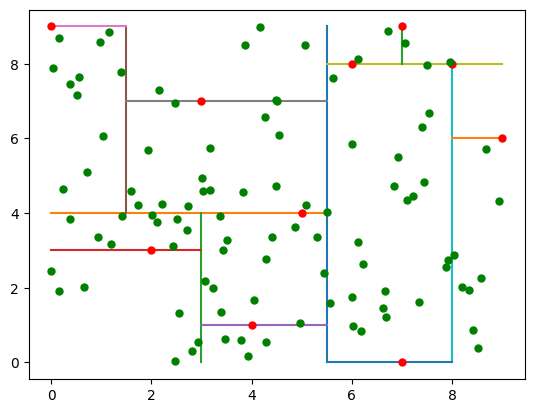

In [136]:
import matplotlib.pyplot as plt
import numpy as np

train_2d = np.array([[0, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 0], [8, 8], [7, 9], [9, 6]])

class TreeNode:
    def __init__(self) -> None:
        pass

def drawSplit(min, max, median, axis):
    if axis == 0:
        plt.plot([min, max],[median,median])
    else:
        plt.plot([median, median],[min, max])


def draw_kd_tree(listOfPoints, depth, x_min, x_max, y_min, y_max):
    if len(listOfPoints) > 0:
        axis = depth % listOfPoints.shape[1]
        median = np.median(listOfPoints, axis=0)[axis]
        
        left = []
        right = []
        for point in listOfPoints:
            if point[axis] < median:
                left.append(point)
            elif point[axis] > median:
                right.append(point)
        
        if axis == 0:
            plt.plot([median, median],[y_min, y_max])
            draw_kd_tree(np.array(left), depth+1, x_min, median, y_min, y_max)
            draw_kd_tree(np.array(right), depth+1, median, x_max, y_min, y_max)
        elif axis == 1:
            plt.plot([x_min, x_max],[median,median])
            draw_kd_tree(np.array(left), depth+1, x_min, x_max, y_min, median)
            draw_kd_tree(np.array(right), depth+1, x_min, x_max, median, y_max)

        

depth = 0
x_min = np.min(train_2d, axis=0)[0]
x_max = np.max(train_2d, axis=0)[0]
y_min = np.min(train_2d, axis=0)[1]
y_max = np.max(train_2d, axis=0)[1]
draw_kd_tree(train_2d, 0, x_min, x_max, y_min, y_max)

[plt.plot(point[0], point[1], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red") for point in train_2d]

test_data_size = 100
test_2d = np.array(list(map(lambda x: x*9 ,np.random.rand(test_data_size*2)))).reshape((test_data_size, 2))
[plt.plot(point[0], point[1], marker="o", markersize=5, markeredgecolor="green", markerfacecolor="green") for point in test_2d]


plt.show()

Powyższ wizualizacja redukuje hiperprzestrzeń do płaszczyzny, a hiperpłaszczyznę do odcinka, jednak pozwala w bardzo obrazowy sposób przedstawić zasadę działania drzewa KD.  
Jak widzimy, tworząc drzewo KD dzielimy badany obszar na coraz to mniejsze obszary, które ostatecznie będą tworzyć nasze klasy. W przypadku 2D wyznaczone prostokąty odpowiadają liściom drzewa, a wszystkie punkty znajdujące się w jednym prostokącie należą do tej samej klasy.  
Można zauważyć, że bazując wyłącznie na podziale obszaru przez mediany i nie wprowadzając nazbyt dużego zbioru punktów budujących drzewo, możemy otrzymać dość duży obszary nadające tą samą klasę punktom o dużej rozbieżności ich koordynat, (np.: (5.5, 0)(8, 8) na rysuku, gdzie wartości *y* pochodzą z niemalże całego przedziału dostępnych wartości).  
Z drugiej strony, nie wolno przesadzić z wielkością zbioru budującego drzewo KD, zwłaszcza dla małej ilości wymiarów, aby nie otrzymać zbyt dużej granulacji powstałych klas.